In [1]:
from tilebox.workflows import Client

from sentinel2zarr import AreaOfInterest, RegionOfInterest, Sentinel2ToZarr
import morecantile

## Define a target region and time frame

In [50]:
aoi = AreaOfInterest(4.5, 52.2, 5.1, 52.6)  # amsterdam

last_10_days = ("2025-06-20", "2025-06-30")

tms = morecantile.tms.get("WebMercatorQuad")
resolution = tms.matrix(14).cellSize  # resolution in meters at web mercator zoom level 14 ~= 10m
print(f"Resolution: {resolution} meters")

Resolution: 9.55462853564703 meters


## Submit a job

In [13]:
task = Sentinel2ToZarr(
    ["S2A_S2MSI2A", "S2B_S2MSI2A", "S2C_S2MSI2A"],
    RegionOfInterest(aoi, last_10_days),
    "EPSG:3857",
    resolution
)

job_client = Client().jobs()
job = job_client.submit(
    "amsterdam-cloudfree-mosaic-last-10-days", task,
)

Job(id=UUID('0197c066-2a61-0dbf-71f4-78b6526070d7'), name='amsterdam-cloudfree-mosaic-last-10-days', trace_parent='00-bc54dd470e881bcb3cb801f721ed1941-1affdbf68155d6af-01', state=<JobState.QUEUED: 1>, canceled=False)

In [6]:
job_client.display(job)

## Visualize the result

In [7]:
from sentinel2zarr import zarr_storage
from zarr.storage import ObjectStore
import xarray as xr
import numpy as np

In [8]:
output_zarr_bucket = zarr_storage(f"s2-zarr/{job.id}/cube")
cube = xr.open_zarr(ObjectStore(output_zarr_bucket), zarr_format=3, consolidated=False)

In [10]:
reflectances = cube.mosaic.transpose("y", "x", "band")

In [35]:
# apply a simple brighten factor to our reflectances
rgb = ((reflectances * 2).clip(0, 1) * 255).astype(np.uint8)
rgb_out = rgb.load()

# add an alpha band for masking out missing values
# alpha band: 0 for transparent (mask is True), 255 for opaque (mask is False)
mask = (rgb_out==0).any("band")
alpha_band = np.where(mask.values, 0, 255).astype(np.uint8)
rgba = np.concatenate((rgb_out.values, alpha_band.reshape(rgb.sizes["y"], rgb.sizes["x"], 1)), axis=2) 


In [36]:
import matplotlib.pyplot as plt

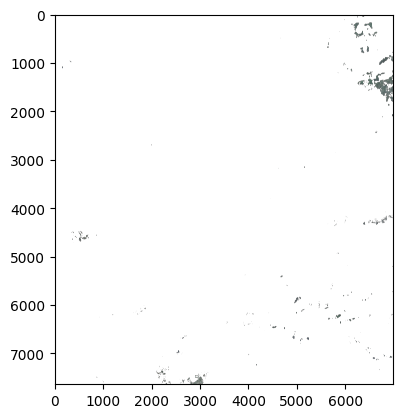

In [39]:
plt.imshow(rgba)

## Save it as georeferenced GeoTiff

In [40]:
georeference = aoi.as_geobox("EPSG:3857", resolution)

In [41]:
from geotiff import save_numpy_to_geotiff

In [43]:
save_numpy_to_geotiff(rgba, georeference, "amsterdam.tif")

Successfully saved GeoTIFF: amsterdam.tif
